In [1]:
%load_ext autoreload
%autoreload 2

import torch
import pyro
from pyro import distributions as dist
from pyro import poutine
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from model import YModel

import matplotlib.pyplot as plt
%matplotlib inline

# Model

## Toy model

Input X - corresponds to any kind of phase space input - some **distribution** with prior.
Input $\mu$ - corresponds to parameters of surrogate, ie - size of detector, magnetic field, etc. - a **number**.

Define some functions f, g - those can be varied. Probably, bettern to stick with some types of them, ie:
continous, pereodic, polynomial, ...


$$X \sim U(x_{min}, x_{max}), \ \ \mu \sim \delta(\mu - \mu_0) $$

$$latent\_x \sim  \mathcal{N} (latent\_x | X, 1)$$


$$ f(\alpha) = a + b \alpha  $$
$$ g(\alpha) = d * \alpha $$

$$y \sim \mathcal{N}(y|f(latent\_x) + g(\mu), 1)$$

### Problem statement

1. Fit GAN/GP/NV to match p(y|X,mu)

2. Solve optimisaiton problem of the choise:
 - $argmin_{mu} (y - Y_0) ^2 $
 - $argmax_{mu} p(y|mu) = \int p(y|X,mu) p(X) dx$
 - $etc$



## Make model with `pyro`


## Investigation of the model

In [93]:
y_sampler = YModel(init_mu=torch.tensor([0.,]))

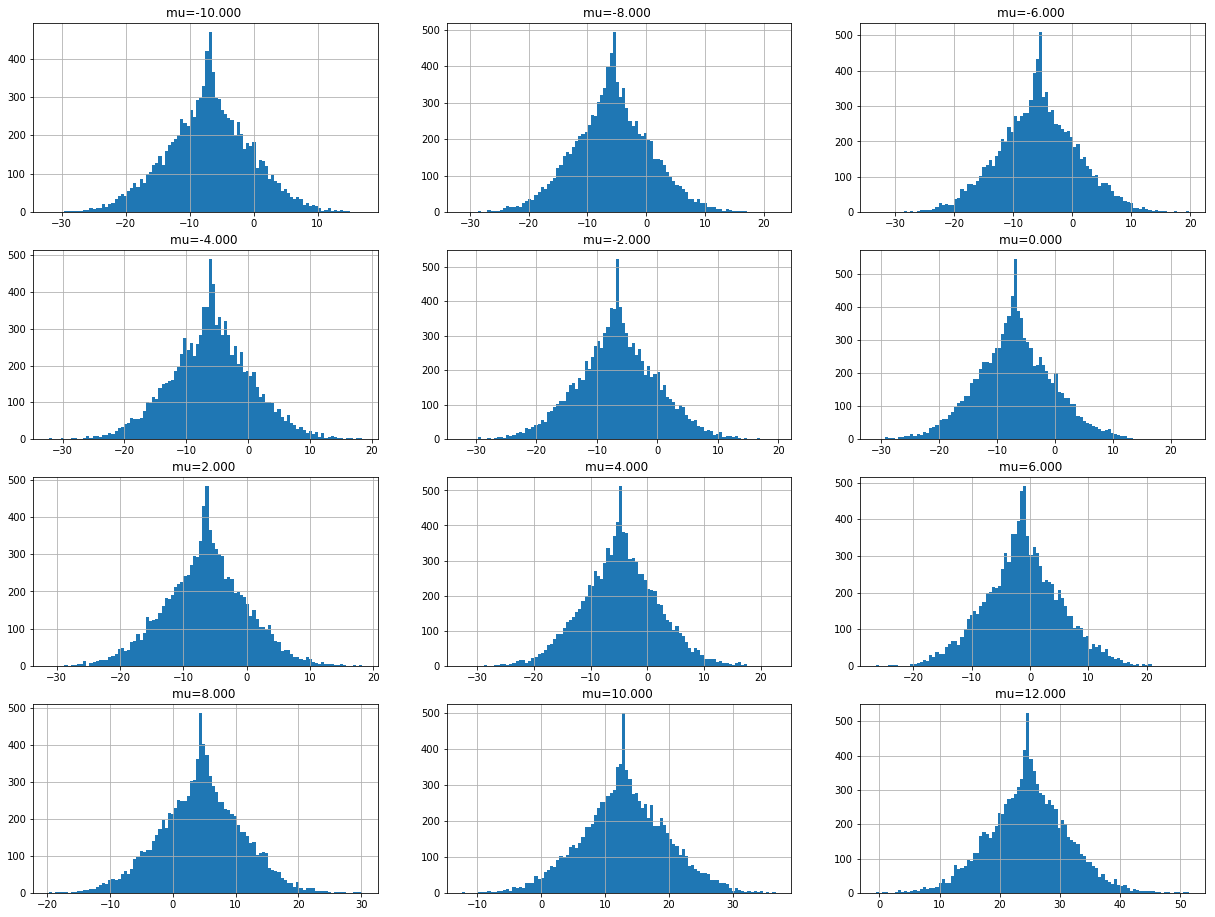

In [77]:
plt.figure(figsize=(21,16))
mu = list(range(-10, 13, 2))
for i in range(4):
    for j in range(3):
        plt.subplot(4,3, i*3 + j + 1)
        y_sampler.make_condition_sample({'mu': torch.tensor([float(mu[i*3 + j])] * 10000)})
        plt.hist(y_sampler.condition_sample().detach().numpy(), bins=100);
        plt.grid()
        #plt.legend()
        plt.title("mu={:.3f} ".format(mu[i*3 + j]))

CPU times: user 808 ms, sys: 32 ms, total: 840 ms
Wall time: 849 ms


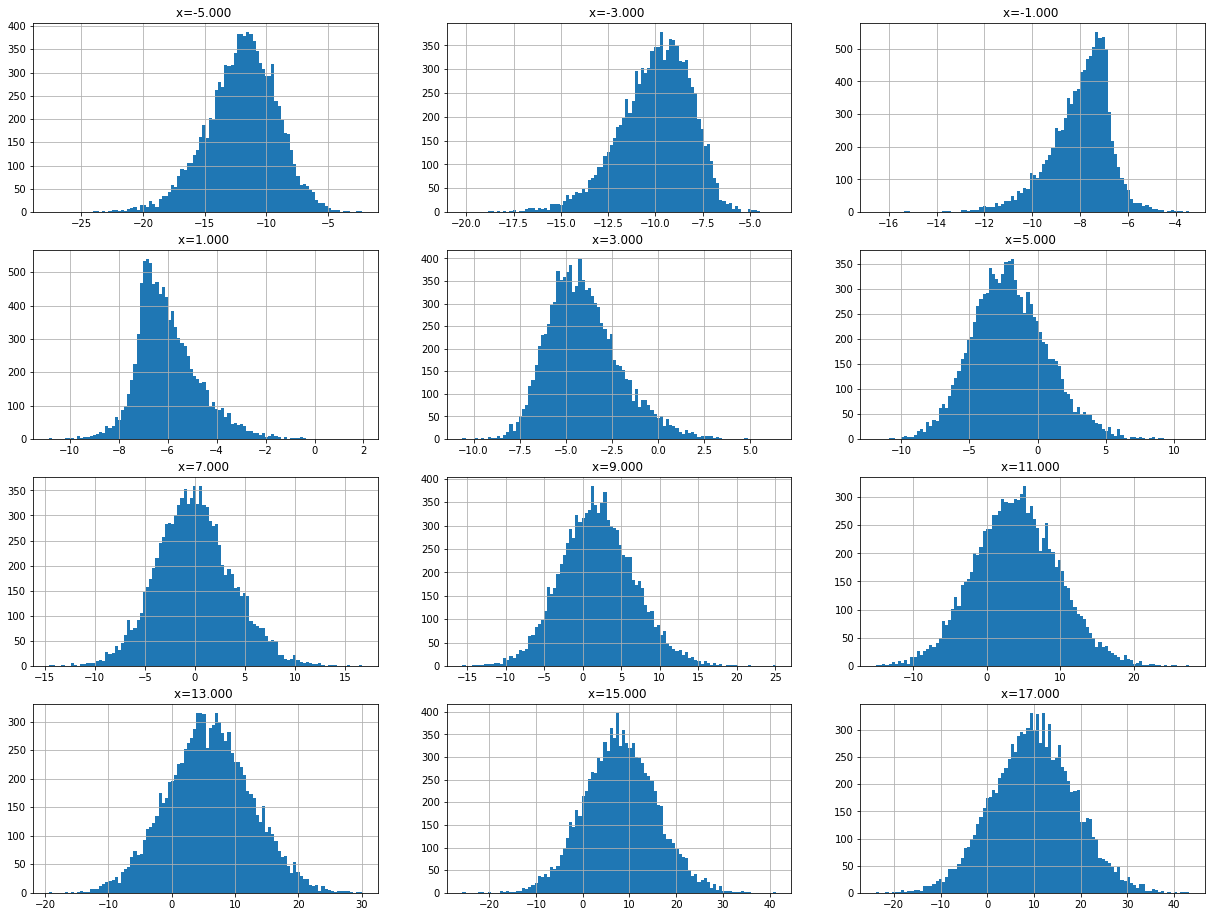

In [78]:
%%time
plt.figure(figsize=(21,16))
x_r = list(range(-5, 18, 2))
for i in range(4):
    for j in range(3):
        plt.subplot(4,3, i*3 + j + 1)
        y_sampler.make_condition_sample({'X': torch.tensor([float(x_r[i*3 + j])] * 10000).reshape(-1,1)})
        plt.hist(y_sampler.condition_sample(10000).detach().numpy(), bins=100);
        plt.grid()
        #plt.legend()
        plt.title("x={:.3f} ".format(x_r[i*3 + j]))

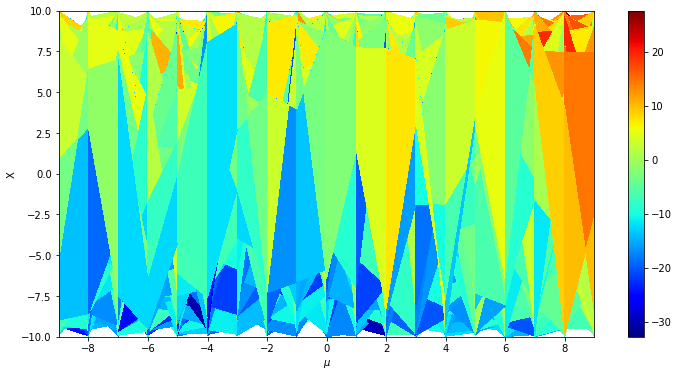

In [5]:
my_cmap = plt.cm.jet
my_cmap.set_under('white')

mu_r = torch.arange(-100, 100, 1, dtype=torch.double)
x_r = y_sampler.x_dist.sample(torch.Size([1000, len(mu_r)])).double()

y_sampler.make_condition_sample({'mu': mu_r, 'X': x_r})
y = y_sampler.condition_sample()


plt.figure(figsize=(12,6))

mask = torch.abs(mu_r) < 10
plt.pcolormesh(mu_r[mask], x_r[:, mask], y[:, mask], cmap=my_cmap);
plt.colorbar()
plt.xlabel(r'$\mu$');
plt.ylabel("X");

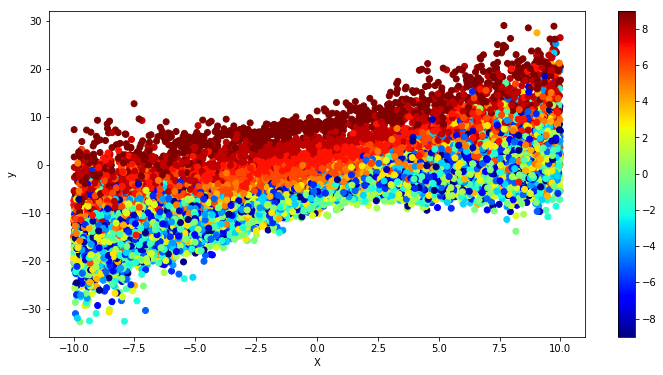

In [6]:
mask = torch.abs(mu_r) < 10
plt.figure(figsize=(12,6))
plt.scatter(x_r[:, mask], y[:, mask],
            c=mu_r[mask].reshape(-1,1).repeat(1, x_r.shape[0]).transpose(1,0), cmap=my_cmap)
plt.colorbar()
plt.xlabel("X");
plt.ylabel("y");

In [12]:
# plt.figure(figsize=(12,6))
# plt.pcolormesh(mu_r, x_r, y, cmap=my_cmap);
# plt.colorbar()
# plt.xlabel(r'$\mu$');
# plt.ylabel("X");

### 2d case for mu

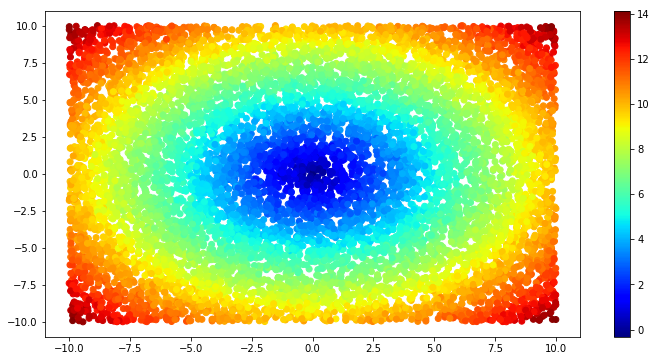

In [100]:
mu = dist.Uniform(-10,10).sample([10000, 2])
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1000]))#.double()
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})



y = y_sampler.condition_sample()
y_mean = y.mean(dim=1)

plt.figure(figsize=(12,6))
plt.scatter(mu[:,0], mu[:, 1], c=y_mean, cmap=my_cmap)
plt.colorbar()

In [95]:
import numpy as np
mu = dist.Uniform(-10,10).sample([1000, 2])
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 10000]))#.double()
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
samples = y_sampler.condition_sample()
rs = OptLoss.R(samples, 5)

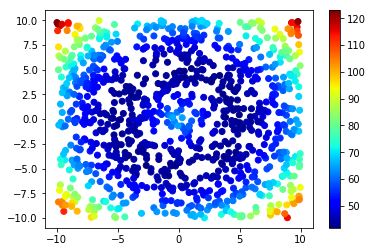

In [96]:
plt.scatter(mu[:,0], mu[:,1], c=rs,  cmap=my_cmap)
#plt.yscale("log")
plt.colorbar()

In [97]:
import numpy as np
mu = dist.Uniform(-10,10).sample([1000, 2])
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 10000]))#.double()
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
samples = y_sampler.condition_sample()
rs = OptLoss.SigmoidLoss(samples, 5, 10)

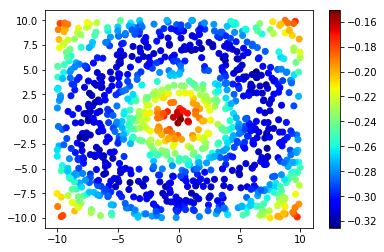

In [98]:
plt.scatter(mu[:,0], mu[:,1], c=rs,  cmap=my_cmap)
#plt.yscale("log")
plt.colorbar()

## Statistic of interest

$$r = \frac{1}{N} \sum\limits_{i=0}^{N} || y_i - Y ||_2^2$$

In [7]:
from model import OptLoss

## Approaches to solve the problem

### First one

  1. Make approximation of this model:

  $$p(y | \mu)$$

  With GANs or some other techniques.
  

  2. Sample $\{ y_i \}_{i=0}^{B} \sim p(y | \mu)$
  
  
  3. Calc $r = R(\{ y_i \}_{i=0}^{B})$
  
  
  4. Find $\frac{\partial r}{\partial \mu}$
  
### Second one


  1. Make approximation of this model:

  $$p(r | \mu)$$
  
  
  2. Sample $r \sim p(r | \mu)$
  
  
  3. Find $\frac{\partial r}{\partial \mu}$

In [21]:
import numpy as np
mu = torch.arange(-25,25,0.5).reshape(-1,1).float()
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 10000]))
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
samples = y_sampler.condition_sample()
rs = OptLoss.R(samples, -5)

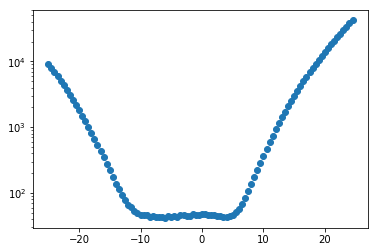

In [22]:
plt.scatter(mu, rs)
plt.yscale("log")

In [26]:
mu[np.argmin(rs)], torch.min(rs)

(tensor([-6.]), tensor(41.8091))

### Sigmoid loss

Text(0.5, 1.0, 'loss')

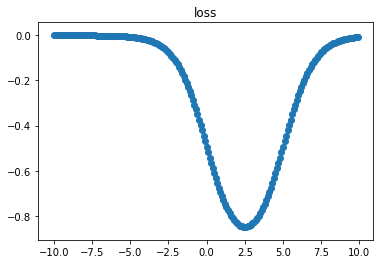

In [218]:
plt.scatter(np.arange(-10, 10, 0.1), OptLoss.SigmoidLoss(torch.tensor(np.arange(-10, 10, 0.1)).reshape(-1,1), 0, 5))
plt.title("loss")

In [28]:
import numpy as np
mu = torch.linspace(-25, 25, 1000).reshape(-1,1).float()
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 10000]))
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
samples = y_sampler.condition_sample()
rs = OptLoss.SigmoidLoss(samples, -5, 5)

Text(0.5, 1.0, 'Average over X loss value')

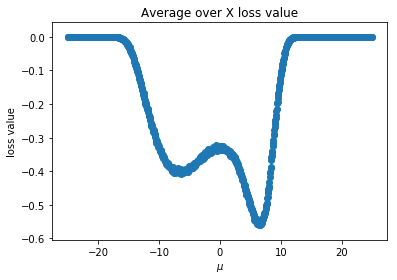

In [30]:
plt.scatter(mu, rs)
plt.xlabel("$\mu$")
plt.ylabel("loss value")
plt.title("Average over X loss value")
#plt.yscale("log")

In [32]:
mu[np.argmin(rs)], torch.min(rs)

(tensor([6.5315]), tensor(-0.5607))

## tests

In [2]:
from utils import generate_data

In [5]:
device = torch.device("cuda", 0)
d, i = generate_data(y_sampler, device, 100)
i.shape

torch.Size([100, 2])

In [26]:
from utils import DistPlotter, sample_noise
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, noise_dim, out_dim, hidden_dim=100, input_param=2):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(noise_dim + input_param, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim, out_dim)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)

    def forward(self, z, params):
        """
            Generator takes a vector of noise and produces sample
        """
        
        #z = torch.cat([z, params.repeat(z.shape[0], 1)], dim=1)
        z = torch.cat([z, params], dim=1)
        h1 = torch.tanh(self.fc1(z))
        h2 = F.leaky_relu(self.fc2(h1))
        y_gen = self.fc3(h2)
        return y_gen

In [27]:
y_sampler = YModel(init_mu=torch.tensor([0.]))
generator = Generator(5,1, input_param=2).to(device)
f_noise = torch.Tensor(sample_noise(10000, 5)).to(device)
dist_plotter = DistPlotter(y_sampler, generator, f_noise, device, mu_dim=1)

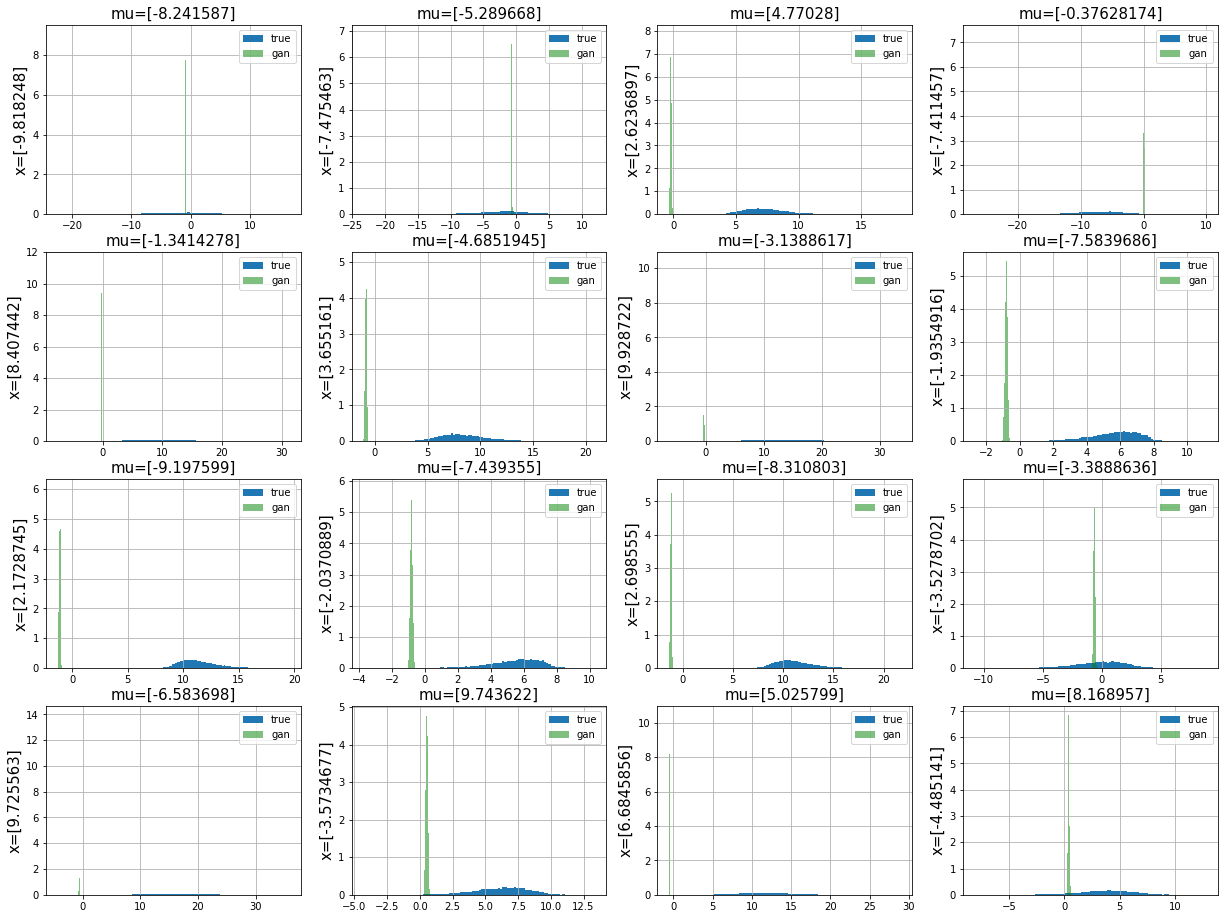

In [28]:
mu_range = (-10, 10)
f = dist_plotter.draw_conditional_samples(mu_range)
#experiment.log_figure("conditional_samples_{}".format(epoch), f)
plt.show()

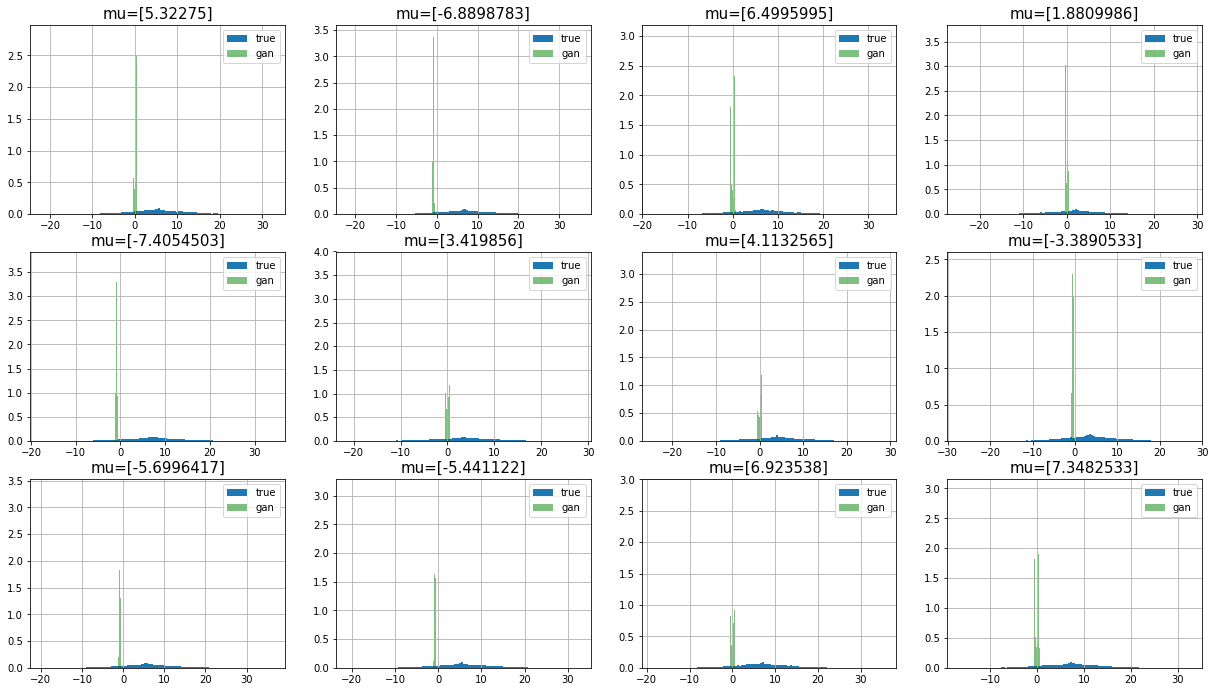

In [29]:
mu_range = (-10,10)
f = dist_plotter.draw_mu_samples(mu_range)
#experiment.log_figure("mu_samples_{}".format(epoch), f)
#plt.close(f)
plt.show()

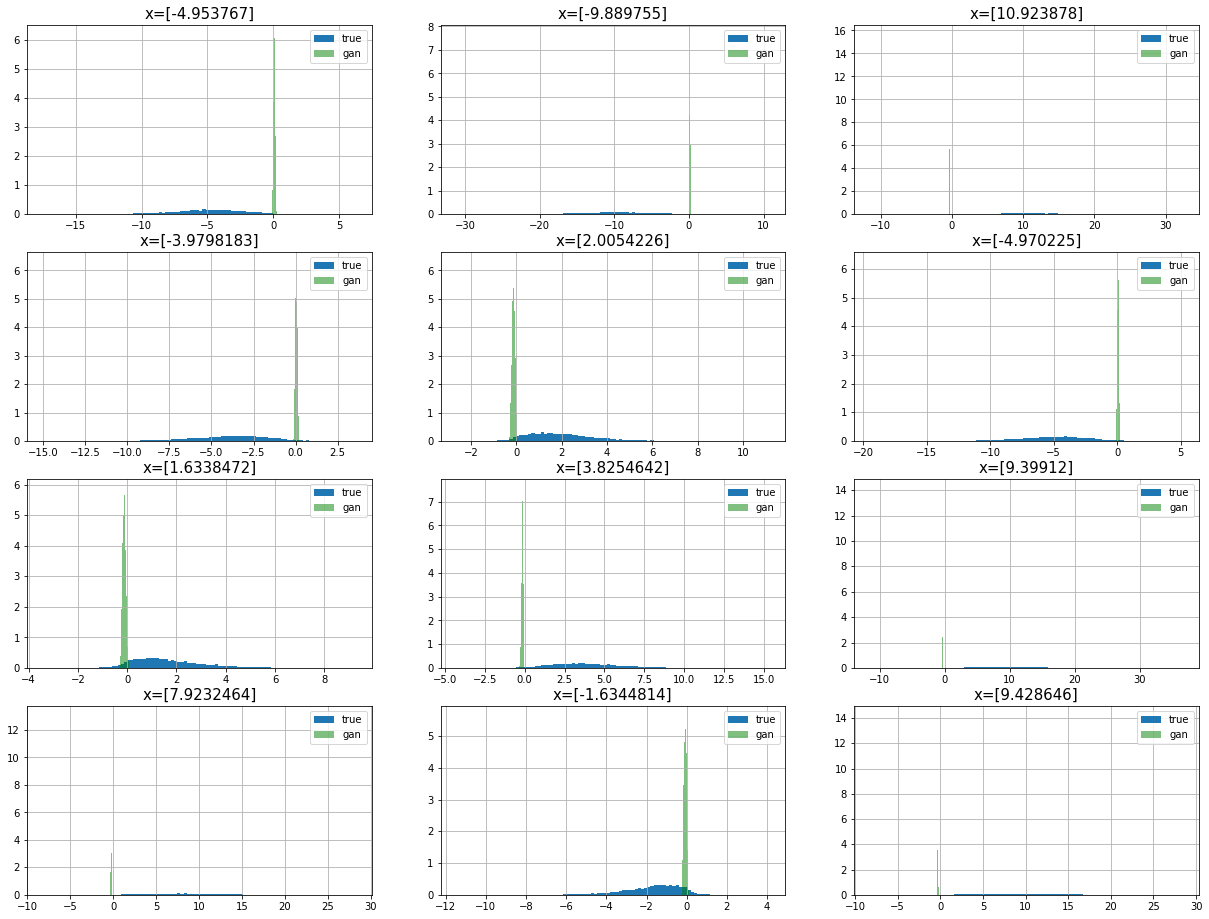

In [30]:
x_range = (-12,12)
f = dist_plotter.draw_X_samples(x_range)
#experiment.log_figure("x_samples_{}".format(epoch), f)
plt.show()